In [1]:
import warnings
import os

os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore')

# Методы Монте Карло

## Создание модели

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class BayesianTransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, n_heads=4, hidden_dim=256, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # (batch, 1, dim)
        x = self.transformer(x).squeeze(1)  # (batch, dim)
        return self.classifier(x)

## Загрузка данных

In [3]:
import pandas as pd
embedding_df = pd.read_csv("sequence_embeddings.csv")

In [4]:
# Словарь соответствий
label_mapping = {
    'line': 'line/l1',
    'l1': 'line/l1',
    'gypsy': 'gypsy/copia',
    'copia': 'gypsy/copia',
    'hat': 'hat/mudr/cacta',
    'mudr': 'hat/mudr/cacta',
    'cacta': 'hat/mudr/cacta',
    'helitron': 'helitron'  # без изменений, но можно оставить для явности
}

# Применяем замену
embedding_df['label'] = embedding_df['label'].map(label_mapping).fillna(embedding_df['label'])

In [5]:
unique_labels = list(set(label_mapping.values()))
label2id = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = [label2id[label] for label in embedding_df["label"]]
embedding_df["label"] = numeric_labels

## Обработка и подготовка данных

In [6]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

feature_cols = [c for c in embedding_df.columns if c not in ["label", "organism"]]
X = embedding_df[feature_cols].values
y = embedding_df["label"].values

# Масштабирование
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1765, random_state=42, stratify=y
)

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

## Обучение модели

In [7]:
device = torch.device("cpu")
model = BayesianTransformerClassifier(input_dim=X.shape[1], num_classes=len(np.unique(y)))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

BayesianTransformerClassifier(
  (embedding): Linear(in_features=256, out_features=256, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=4

Epoch 1, Train Loss: 0.9598
Epoch 2, Train Loss: 0.9118
Epoch 3, Train Loss: 0.9030
Epoch 4, Train Loss: 0.8904
Epoch 5, Train Loss: 0.8815
Epoch 6, Train Loss: 0.8722
Epoch 7, Train Loss: 0.8780
Epoch 8, Train Loss: 0.8679
Epoch 9, Train Loss: 0.8680
Epoch 10, Train Loss: 0.8682
Epoch 11, Train Loss: 0.8554
Epoch 12, Train Loss: 0.8592
Epoch 13, Train Loss: 0.8490
Epoch 14, Train Loss: 0.8488
Epoch 15, Train Loss: 0.8506
Epoch 16, Train Loss: 0.8593
Epoch 17, Train Loss: 0.8443
Epoch 18, Train Loss: 0.8382
Epoch 19, Train Loss: 0.8426
Epoch 20, Train Loss: 0.8305
Epoch 21, Train Loss: 0.8665
Epoch 22, Train Loss: 0.8277
Epoch 23, Train Loss: 0.8459
Epoch 24, Train Loss: 0.8327
Epoch 25, Train Loss: 0.8265
Epoch 26, Train Loss: 0.8256
Epoch 27, Train Loss: 0.8404
Epoch 28, Train Loss: 0.8333
Epoch 29, Train Loss: 0.8275
Epoch 30, Train Loss: 0.8280
Epoch 31, Train Loss: 0.8145
Epoch 32, Train Loss: 0.8250
Epoch 33, Train Loss: 0.8030
Epoch 34, Train Loss: 0.7931
Epoch 35, Train Loss: 0

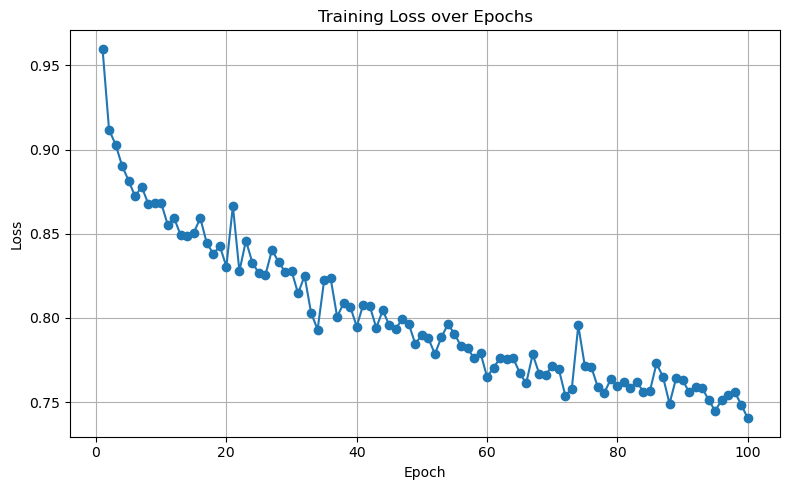

In [8]:
import matplotlib.pyplot as plt

n_epochs = 100
train_losses = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Метрики до применения методов Монте Карло

In [9]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.numpy()

        outputs = model(xb)
        pred_labels = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(pred_labels)
        all_true.extend(yb)

acc = accuracy_score(all_true, all_preds)
report = classification_report(all_true, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

Test Accuracy: 0.6610
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       191
           1       0.00      0.00      0.00         8
           2       0.71      0.78      0.74       294
           3       0.29      0.21      0.24        38

    accuracy                           0.66       531
   macro avg       0.41      0.40      0.40       531
weighted avg       0.64      0.66      0.65       531



# Байесовская оптимизация гиперпараметров

In [18]:
import optuna
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

def objective(trial):
    # Гиперпараметры, которые будут подбираться
    hidden_dim = trial.suggest_categorical('hidden_dim', [128, 256, 512])
    n_heads = trial.suggest_categorical('n_heads', [2, 4, 8])
    n_layers = trial.suggest_int('n_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)

    model = BayesianTransformerClassifier(
        input_dim=256,
        num_classes=4,
        n_heads=n_heads,
        hidden_dim=hidden_dim,
        n_layers=n_layers,
        dropout=dropout
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    model.train()
    for epoch in range(5):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Валидация
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for xb, yb in train_loader:
            xb = xb.to(device)
            preds = model(xb)
            preds = preds.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_true.extend(yb)

    acc = accuracy_score(all_true, all_preds)
    return acc

In [19]:
study = optuna.create_study(direction='maximize')  # maximize accuracy
study.optimize(objective, n_trials=30)  # 30 проб

trial = study.best_trial
print(f"Точность: {trial.value:.4f}")
print("Лучшие гиперпараметры:", trial.params)

[I 2025-06-14 22:30:07,310] A new study created in memory with name: no-name-856962d1-c42b-42d4-82c7-960f938e4d50
[I 2025-06-14 22:30:12,108] Trial 0 finished with value: 0.6674747474747474 and parameters: {'hidden_dim': 256, 'n_heads': 8, 'n_layers': 1, 'dropout': 0.2312126734624798, 'lr': 0.0001561461091174118}. Best is trial 0 with value: 0.6674747474747474.
[I 2025-06-14 22:30:30,316] Trial 1 finished with value: 0.6816161616161616 and parameters: {'hidden_dim': 512, 'n_heads': 4, 'n_layers': 4, 'dropout': 0.2853559825417515, 'lr': 4.063476181587253e-05}. Best is trial 1 with value: 0.6816161616161616.
[I 2025-06-14 22:30:41,688] Trial 2 finished with value: 0.4997979797979798 and parameters: {'hidden_dim': 512, 'n_heads': 2, 'n_layers': 3, 'dropout': 0.1246940059588349, 'lr': 0.0009538894941356564}. Best is trial 1 with value: 0.6816161616161616.
[I 2025-06-14 22:30:48,367] Trial 3 finished with value: 0.6262626262626263 and parameters: {'hidden_dim': 256, 'n_heads': 4, 'n_layers'

Точность: 0.6857
Лучшие гиперпараметры: {'hidden_dim': 512, 'n_heads': 4, 'n_layers': 3, 'dropout': 0.3176009833087946, 'lr': 6.692421872940222e-05}


In [23]:
best_params = study.best_trial.params
model = BayesianTransformerClassifier(
    input_dim=256,
    num_classes=4,
    n_heads=best_params['n_heads'],
    hidden_dim=best_params['hidden_dim'],
    n_layers=best_params['n_layers'],
    dropout=best_params['dropout']
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = torch.nn.CrossEntropyLoss()

Epoch 1, Train Loss: 0.9889
Epoch 2, Train Loss: 0.8866
Epoch 3, Train Loss: 0.8522
Epoch 4, Train Loss: 0.8381
Epoch 5, Train Loss: 0.8222
Epoch 6, Train Loss: 0.7997
Epoch 7, Train Loss: 0.7872
Epoch 8, Train Loss: 0.7734
Epoch 9, Train Loss: 0.7726
Epoch 10, Train Loss: 0.7672
Epoch 11, Train Loss: 0.7636
Epoch 12, Train Loss: 0.7453
Epoch 13, Train Loss: 0.7374
Epoch 14, Train Loss: 0.7318
Epoch 15, Train Loss: 0.7194
Epoch 16, Train Loss: 0.7060
Epoch 17, Train Loss: 0.7103
Epoch 18, Train Loss: 0.6909
Epoch 19, Train Loss: 0.7090
Epoch 20, Train Loss: 0.6828
Epoch 21, Train Loss: 0.6701
Epoch 22, Train Loss: 0.6711
Epoch 23, Train Loss: 0.6584
Epoch 24, Train Loss: 0.6411
Epoch 25, Train Loss: 0.6496
Epoch 26, Train Loss: 0.6290
Epoch 27, Train Loss: 0.6281
Epoch 28, Train Loss: 0.6178
Epoch 29, Train Loss: 0.6060
Epoch 30, Train Loss: 0.6068
Epoch 31, Train Loss: 0.5868
Epoch 32, Train Loss: 0.5707
Epoch 33, Train Loss: 0.5680
Epoch 34, Train Loss: 0.5691
Epoch 35, Train Loss: 0

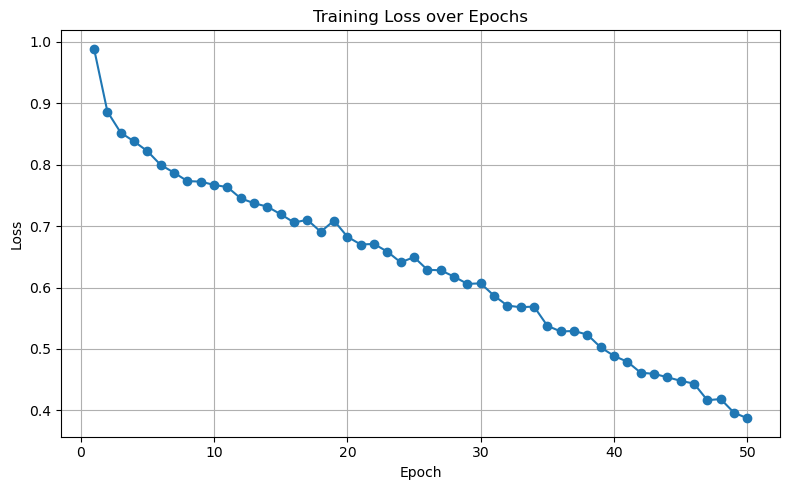

In [24]:
import matplotlib.pyplot as plt

n_epochs = 50
train_losses = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.numpy()

        outputs = model(xb)
        pred_labels = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(pred_labels)
        all_true.extend(yb)

acc = accuracy_score(all_true, all_preds)
report = classification_report(all_true, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

Test Accuracy: 0.6648
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       191
           1       0.50      0.38      0.43         8
           2       0.70      0.79      0.74       294
           3       0.33      0.16      0.21        38

    accuracy                           0.66       531
   macro avg       0.54      0.48      0.50       531
weighted avg       0.65      0.66      0.65       531



# Семплирование для оценки неопределенности предсказания 

MC Точность: 0.6667


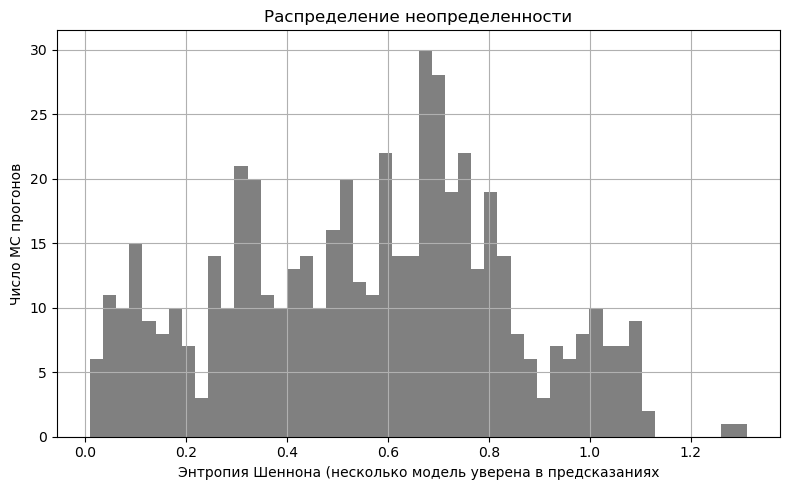

In [26]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def monte_carlo_sampling(model, dataloader, n_samples=30):
    model.train()  # включаем drop out
    
    all_sampled_preds = []

    for _ in range(n_samples):
        sampled_preds = []
        with torch.no_grad():
            for xb, _ in dataloader:
                xb = xb.to(device)
                outputs = model(xb)
                probs = torch.softmax(outputs, dim=1)
                sampled_preds.append(probs.cpu().numpy())
        all_sampled_preds.append(np.concatenate(sampled_preds, axis=0))

    all_sampled_preds = np.stack(all_sampled_preds, axis=0)  # [n_samples, N, num_classes]
    return all_sampled_preds

# Применим MC sampling
n_samples = 30
all_preds_mc = monte_carlo_sampling(model, test_loader, n_samples)

# Вычисляем средние вероятности и энтропию
mean_probs = np.mean(all_preds_mc, axis=0)  # [N, num_classes]
pred_labels = mean_probs.argmax(axis=1)

# Оценка неопределенности — дисперсия по классам или энтропия
entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-8), axis=1)  # [N]
uncertainty = entropy  # можно также использовать np.var(all_preds_mc, axis=0) для дисперсии

# Сравнение с истинными значениями
all_true = []
for _, yb in test_loader:
    all_true.extend(yb.numpy())

acc = accuracy_score(all_true, pred_labels)
print(f"MC Точность: {acc:.4f}")

# распределение неопределенности
plt.figure(figsize=(8, 5))
plt.hist(uncertainty, bins=50, color='gray')
plt.title("Распределение неопределенности")
plt.xlabel("Энтропия Шеннона (несколько модель уверена в предсказаниях")
plt.ylabel("Число MC прогонов")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
def mc_predict(model, xb, num_samples=20):
    model.train()  # включаем dropout
    preds = torch.stack([F.softmax(model(xb), dim=1) for _ in range(num_samples)])
    return preds.mean(dim=0), preds.std(dim=0)

from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_true = []
all_uncertainty = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.numpy()
        mean_probs, std_probs = mc_predict(model, xb)
        pred_labels = mean_probs.argmax(dim=1).cpu().numpy()
        uncertainty = std_probs.mean(dim=1).cpu().numpy()

        all_preds.extend(pred_labels)
        all_true.extend(yb)
        all_uncertainty.extend(uncertainty)

acc = accuracy_score(all_true, all_preds)
print(f"Validation Accuracy: {acc:.4f}")

Validation Accuracy: 0.6573


# Монте-Карло интегрирование для оценки метрик + доверительные интервалы

In [28]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score

def mc_metrics_with_ci(model, dataloader, n_samples=30, ci_level=0.95):
    from scipy.stats import norm
    z = norm.ppf(1 - (1 - ci_level) / 2)  # 95%

    model.train()

    all_metrics = {
        'accuracy': [],
        'f1': [],
        'precision': []
    }

    for _ in range(n_samples):
        all_preds = []
        all_true = []
        all_probs = []

        with torch.no_grad():
            for xb, yb in dataloader:
                xb = xb.to(device)
                outputs = model(xb)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()

                preds = probs.argmax(axis=1)
                all_preds.extend(preds)
                all_true.extend(yb.numpy())
                all_probs.extend(probs[:, 1])

        acc = accuracy_score(all_true, all_preds)
        f1 = f1_score(all_true, all_preds, average='weighted')

        prec = precision_score(all_true, all_preds, average='weighted')

        all_metrics['accuracy'].append(acc)
        all_metrics['f1'].append(f1)
        all_metrics['precision'].append(prec)

    results = {}
    for key, values in all_metrics.items():
        values = np.array(values)
        mean = np.mean(values)
        std = np.std(values)
        ci = z * std / np.sqrt(n_samples)
        results[key] = {
            'mean': mean,
            'std': std,
            'ci_lower': mean - ci,
            'ci_upper': mean + ci
        }

    return results

In [29]:
results = mc_metrics_with_ci(model, test_loader, n_samples=30)

for metric, stats in results.items():
    print(f"{metric.capitalize()}: {stats['mean']:.4f} ± {stats['std']:.4f}  "
          f"(95% CI: {stats['ci_lower']:.4f} – {stats['ci_upper']:.4f})")

Accuracy: 0.6374 ± 0.0131  (95% CI: 0.6327 – 0.6421)
F1: 0.6259 ± 0.0133  (95% CI: 0.6212 – 0.6307)
Precision: 0.6197 ± 0.0138  (95% CI: 0.6148 – 0.6247)
